# IRC

## outline:

- pre IRC
    - load mat (the neural recording file with behavior)
    - convert to IRC input (state, action, task)
- IRC
- post IRC
    - load the inverse file
    - generate belief, and compute likelihood for each trial
    - convert belief to world units
    - convert belief to relative coord, and eye coord
- analysis
    - find when IRC belief is better than state (use task, time, likelihood.)

# Pre IRC

convert the mat data file (with neural data) into (states, actions, tasks) for IRC.


## prepare

In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [1338]:
from scipy.io import loadmat
import numpy as np
from notification import notify
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import pickle
import pandas as pd
from plot_ult import *
import warnings

from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from numpy import pi
from stable_baselines3 import TD3
import torch

warnings.filterwarnings('ignore')

In [1319]:
# const
bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
t_total = 24
fontsize = 7; lw = 1
worldscale =200

m = 'm51'
folder='m51_mat_ruiyi'
dens=[0.0001, 0.0005, 0.001,  0.005 ]
idensity=1
density=dens[idensity]
locals().update({m: {}})
figure_path = resdir/'figures'
# datapaths = [i for i in Path(resdir/'mat_ruiyi').glob(f'{m}*.mat')]
datapaths=[i for i in Path(resdir/folder).glob(f'{m}*.mat')]
datapaths

[WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s38.mat'),
 WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s40.mat'),
 WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s41.mat'),
 WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s42.mat'),
 WindowsPath('C:/Users/24455/Desktop/repo/mkdata/m51_mat_ruiyi/m51s43.mat')]

In [1320]:
# helper functions

def set_violin_plot(vp, facecolor, edgecolor, linewidth=1, alpha=1, ls='-', hatch=r''):
    plt.setp(vp['bodies'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha ,ls=ls, hatch=hatch)
    plt.setp(vp['cmins'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cmaxes'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    plt.setp(vp['cbars'], facecolor=facecolor, edgecolor=edgecolor, 
             linewidth=linewidth, alpha=alpha)
    
    linecolor = 'k' if facecolor == 'None' else 'snow'
    if 'cmedians' in vp:
        plt.setp(vp['cmedians'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
    if 'cmeans' in vp:
        plt.setp(vp['cmeans'], facecolor=linecolor, edgecolor=linecolor, 
                 linewidth=linewidth, alpha=alpha)
       
        
def downsample(data, bin_size=20):
    num_bin = data.shape[0] // bin_size
    data_ = data[:bin_size * num_bin]
    data_ = data_.reshape(num_bin, bin_size, data.shape[-1])
    data_ = np.nanmean(data_, axis=1)
    return data_







def convert_location_to_angle(gaze_r, gaze_x, gaze_y, body_theta, body_x, body_y, hor_theta_eye, ver_theta_eye,DT=DT, remove_pre=True):
    '''
        convert the world overhead view location of the 'gaze' location to eye coord. 

        gaze location, the target
        gaze_r, relative distance
        gaze_x, gaze location x
        gaze_y,

        body_theta, heading direction
        body_x, monkey location x
        body_y, 

        hor_theta_eye, actual eye location in eye coord. used here to remove pre saccade (when monkey hasnt seen the target yet)
        ver_theta_eye
    '''

    #hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), gaze_y - body_y) - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    hor_theta = -np.rad2deg(np.arctan2(-(gaze_x - body_x), np.sqrt((gaze_y - body_y)**2 + monkey_height**2))
                            - (body_theta-np.deg2rad(90))).reshape(-1, 1) 
    overshoot_idx = np.where(((gaze_x - body_x) * gaze_x < 0) | (gaze_y < body_y)
                             #| (abs(hor_theta.flatten()) > 60)
                            )[0]
    
    if overshoot_idx.size > 0:
        hor_theta[overshoot_idx[0]:] = np.nan

    k = -1 / np.tan(body_theta); b = body_y - k * body_x
    gaze_r_sign = (k * gaze_x + b < gaze_y).astype(int)
    gaze_r_sign[gaze_r_sign == 0] = -1
    ver_theta = -np.rad2deg(np.arctan2(monkey_height, gaze_r_sign * gaze_r)).reshape(-1, 1)
    overshoot_idx = np.where((gaze_r_sign < 0)
                             #| (abs(ver_theta.flatten()) > 60)
                            )[0]
    if overshoot_idx.size > 0:
        ver_theta[overshoot_idx[0]:] = np.nan
        
    # detect saccade
    if remove_pre:
        if hor_theta_eye.size > 2:
            saccade = np.sqrt((np.gradient(hor_theta_eye) / DT)**2 + 
                            (np.gradient(ver_theta_eye) / DT)**2)
            saccade_start_idx = np.where(saccade > 100)[0]
            saccade_start_idx = saccade_start_idx[0] + 16 if saccade_start_idx.size > 0 else None

            hor_theta[:saccade_start_idx] = np.nan
            ver_theta[:saccade_start_idx] = np.nan
        
    return hor_theta, ver_theta


def compute_error(data1, data2, mask):
    #data1 = data1[~mask]; data2 = data2[~mask]
    #corr = np.corrcoef(data1, data2)
    error = abs(data1 - data2)
    
    rng = np.random.default_rng(seed=0)
    data1_ = data1.copy(); data2_ = data2.copy()
    rng.shuffle(data1_); rng.shuffle(data2_)
    error_shuffle = abs(data1_ - data2_)
    return error



## load raw data (same as ruiyi script)

In [1322]:
# load raw data
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data
    notify(datapath)
    
notify('all done! loaded')

In [1323]:
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        eye_hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        eye_ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
            body_theta, body_x, body_y, 
            eye_hor_theta.reshape(-1), eye_ver_theta.reshape(-1))

        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1,1)
        mw = trial_behv['continuous']['w'][0][0][t_mask].reshape(-1,1)
        if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or \
            abs_dist[-1] < np.sqrt(fx**2 + fy**2)[-1] * 0.3:
            continue

        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        

        # [0.0001 0.0005 0.001  0.005 ]
        if trial_behv['prs'][0][0]['floordensity'] != density:
            continue
        
        Ydownsampled.append([trial_idx, target_variable])
   
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled

    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors)
del m_downsampled, m_extracted_continuous, m_errors

## process the Y downsampled to irc input data (state, action, task)

In [1324]:
irc_input_data={}

for key, data in eval(m).items():
    if not key.endswith('Ydownsampled'):
        continue
    states, actions, tasks=[],[],[]
    
    print(key)
    y=eval(m)[key]
    trial_idces, yy = zip(*y)

    for itrial in range(len(trial_idces)):
        rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw=zip(*yy[itrial])
        # task
        taskx = (fx[0] - mx[0]).astype('float32'); tasky = (fy[0] - my[0]).astype('float32')
        tasks.append([tasky/worldscale,taskx/worldscale])
        # actions
        trialaction=np.stack([mv,mw]).T
        trialaction[:,0]=trialaction[:,0]/worldscale # v need reduce scale
        trialaction[:,1]=trialaction[:,1]/180*pi
        actions.append(trialaction.astype('float32'))

        # states from run the actions
        px, py, heading, v, w = 0,0,0,0,0
        log=[]
        for a in trialaction:
            px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
            log.append([px, py, heading, v, w])
        px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
        log.append([px, py, heading, v, w])
        trialstates=np.array(log)[1:]
        
        states.append(trialstates.astype('float32'))

    irc_input_data[key + '_irc']=(states, actions, tasks)

eval(m).update(irc_input_data)
del irc_input_data

m51s38Ydownsampled
m51s40Ydownsampled
m51s41Ydownsampled
m51s42Ydownsampled
m51s43Ydownsampled


## check the log ll

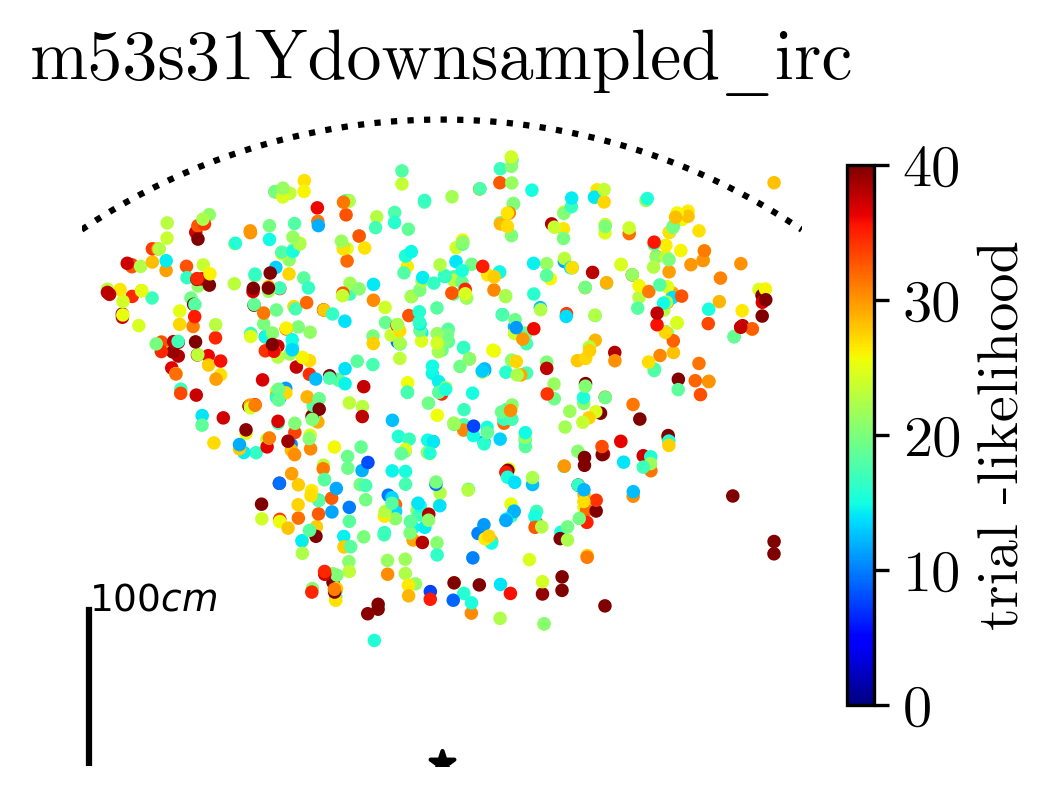

In [466]:

for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    states, actions, tasks=eval(m)[key]
    ll=irc_ll[key+'_ll']

    scattery=np.asarray(tasks)[:,0]
    scatterx=np.asarray(tasks)[:,1]
    scatterv=ll
    vmin=0; vmax=40

    fig, ax = overheadbase(figsize=(3,3))
    # vm=np.max(np.abs(scatterv))
    cax=ax.scatter(scatterx*worldscale, scattery*worldscale,s=5, c=scatterv,cmap='jet', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cax,shrink=0.6, label='trial -likelihood')
    ax.scatter(0,0, marker='*', color='black')
    ax.set_title(key)
    fig.show()

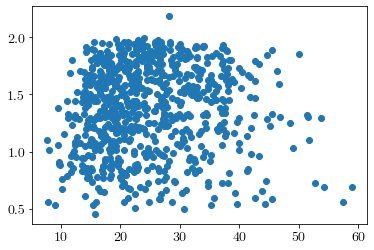

In [467]:
plt.scatter(ll, (scatterx**2+scattery**2)**0.5)
# plt.axis('equal')

### likelihood vs belief-eye correlation

In [470]:
# load the irc belief
with open(resdir/'neuraltest/res/m53s31_0928newformatbelief', 'rb') as f:
    res = pickle.load(f)
irc_valid_trials=np.unique(res['trial_idx'])

In [471]:

# TODO need to fix the key for multi data runs
key=list(eval(m).keys())[0]
    
m_downsampled = {}; m_errors = {}
Ydownsampled = []  # belief task variables
trials_error = []
trials_error_sign = []
trials_target_angle = []
trials_target_distance = []

for itrial in np.unique(res['trial_idx']):

    # prepare to process time series belief into block per trial
    this_mask = (res['trial_idx'] == itrial)
    # print('belief',res['belief'][this_mask].shape)

    # get firefly position from raw data
    trial_behv = trials_behv[itrial]
    trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
    t_mask = (trial_ts > 0) & (
        ~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
    t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
    if t_mask.sum() > 0:
        # remove the first data point to avoid downsample error
        t_mask[np.where(t_mask == True)[0][0]] = False
    fx = downsample(trial_behv['continuous']['xfp']
                    [0][0][t_mask], bin_size=bin_size)
    fy = downsample(trial_behv['continuous']['yfp']
                    [0][0][t_mask], bin_size=bin_size)

    # unppack irc belief mu
    # world monkey x (belief)
    mx = res['belief'][this_mask][:, 0].reshape(-1, 1)
    my = res['belief'][this_mask][:, 1].reshape(-1, 1)
    body_theta = res['belief'][this_mask][:, 2].reshape(-1, 1)
    body_theta=np.deg2rad(body_theta + 90)
    mv = res['belief'][this_mask][:, 3]
    mw = res['belief'][this_mask][:, 4]

    # sometimes belief has one more dt due to sampling error. 
    # remove the first belief
    if len(fx) < len(mx):
        body_theta = body_theta[len(my)-len(fy):]
        mv = mv[len(my)-len(fy):]
        mw = mw[len(my)-len(fy):]
        mx = mx[len(mx)-len(fx):]
        my = my[len(my)-len(fy):]
    # continue the last belief 
    if len(fx) > len(mx):
        body_theta=np.vstack([body_theta,[body_theta[-1,:]]*(len(fy)-len(my))])
        mv=np.vstack([mv,[mv[-1,:]]*(len(fy)-len(my))])
        mw=np.vstack([mw,[mw[-1,:]]*(len(fy)-len(my))])
        mx=np.vstack([mx,[mx[-1,:]]*(len(fx)-len(mx))])
        my=np.vstack([my,[my[-1,:]]*(len(fy)-len(my))])


    # calculate errors (belief mu)
    sx = np.ones_like(fx)
    sy = np.ones_like(fy)
    if my.size > 0:
        fx = np.ones_like(fx) * fx[0]
        fy = np.ones_like(fy) * fy[0]
        sx *= mx[-1]
        sy *= my[-1]
        # my = my + 30
        my = my + 2.5
        fy = fy + 30
        sy = sy + 30

    dx = fx - mx
    dy = fy - my
    rel_dist = np.sqrt(dx**2 + dy**2)
    rel_ang = np.rad2deg(np.arctan2(dy, dx))
    rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)

    if my.size > 0:
        trials_error.append(rel_dist[-1][0])
        trials_error_sign.append(rel_dist[-1][0])
        trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
        trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])

    else:
        trials_error.append(np.nan)
        trials_error_sign.append(np.nan)
        trials_target_angle.append(np.nan)
        trials_target_distance.append(np.nan)

    if my.size > 0:
        d1 = np.sqrt(fx**2 + fy**2)
        r1 = (fx**2 + fy**2) / (2*fx)
        radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

        d2 = np.sqrt(mx**2 + my**2)
        r2 = (mx**2 + my**2) / (2*mx + 1e-8)
        radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

        sign = np.ones_like(rel_dist)
        sign[radian2 < radian1] = -1
        rel_dist = sign * rel_dist
        trials_error_sign[-1] = rel_dist[-1][0]
    abs_dist = np.sqrt(mx**2 + my**2)
    abs_ang = np.rad2deg(np.arctan2(my, mx))

    # calculate relative belief (relative target location rotated by heading)

    rel_lat, rel_for=convert_location_to_relative(
                            mx,
                            my,
                            body_theta,
                            fx,
                            fy,
                            dt=0.1)
        

    # calculate the latent ff position
    
    body_x, body_y = mx.reshape(-1), my.reshape(-1)
    hor_theta = downsample(trial_behv['continuous']['yre']
                           [0][0][t_mask], bin_size=bin_size)
    ver_theta = downsample(trial_behv['continuous']['zre']
                           [0][0][t_mask], bin_size=bin_size)
    
    hor_theta_, ver_theta_ = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
                                                       body_theta.reshape(-1), body_x, body_y,
                                                       hor_theta.reshape(-1), ver_theta.reshape(-1),DT=0.1, remove_pre=False)
    # remove the pre saccade part ?




    # group and save the variables
    target_variable = np.hstack([rel_dist,  # mk belief - target dist
                                 rel_ang,  # mk belief - target agnle
                                 abs_dist,  # mk belief - start dist
                                 abs_ang,
                                 
                                 hor_theta, ver_theta, # actual target in eye coord
                                 hor_theta_,  ver_theta_,  # mk belief target in eye coord
                                 rel_lat.reshape(-1,1), rel_for.reshape(-1,1), # mk belief target in ego centric world xy coord
                                 mx, my,  # mk belief xy 
                                body_theta,  # mk belief heading ,
                                mv.reshape(-1,1), mw.reshape(-1,1)])
    
    Ydownsampled.append([itrial, target_variable])

m_downsampled[key + 'Ydownsampled_belief'] = Ydownsampled
m_errors[key + 'error_belief'] = trials_error; m_errors[key + 'error_sign_belief'] = trials_error_sign
m_errors[key + 'target_angle_belief'] = trials_target_angle; m_errors[key + 'target_distance_belief'] = trials_target_distance

# update the struct
eval(m).update(m_downsampled)
eval(m).update(m_errors)



In [492]:
b,y=eval(m)['m53s31Ydownsampled_belief'],eval(m)['m53s31Ydownsampled']
btrialind, b=zip(*b)
ytrialind, y=zip(*y)
commonind=set(btrialind).intersection(set(ytrialind))
commonindmask=np.array(commonind)
btrialmask=[True if i in commonind else False for i in btrialind ]
ytrialmask=[True if i in commonind else False for i in ytrialind ]

assert np.all(np.array(btrialind)[btrialmask]==np.array(ytrialind)[ytrialmask])

belief=[]
for k,v in zip(btrialmask, b):
    if k:belief.append(v)
groundtruth=[]
for k,v in zip(ytrialmask, y):
    if k:groundtruth.append(v)

sessionll=[]
for k,v in zip(ytrialmask, ll):
    if k:sessionll.append(v)
len(sessionll)


(674, 674)

In [529]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
# belief eye corr
x,y=np.vstack(groundtruth)[:,4],np.vstack(belief)[:,6]
valid=~np.isnan(np.vstack(belief)[:,6])
x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
np.mean(cross_val_score(LinearRegression(),x,y))

lr=LinearRegression()
lr.fit(x,y)

# pred=lr.predict(x)
# err=(y-pred)**2
# err

# groundtruth eye corr
# x,y=y[:,4],y[:,6]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 674 but corresponding boolean dimension is 10720

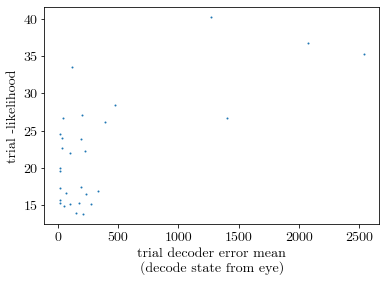

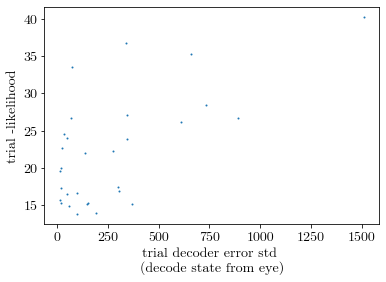

In [547]:
# state eye corr
x,y=np.vstack(groundtruth)[:,4],np.vstack(belief)[:,6]
valid=~np.isnan(np.vstack(belief)[:,6])
x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
np.mean(cross_val_score(LinearRegression(),x,y))

lr=LinearRegression()
lr.fit(x,y)

sessionerrmu,sessionerrstd=[],[]
for b,s in zip(belief, groundtruth):
    x,y=np.vstack(s)[:,4].reshape(-1,1),np.vstack(s)[:,6].reshape(-1,1)
    # valid=~np.isnan(y)
    # x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
    pred=lr.predict(x)
    err=(y-pred)**2
    sessionerrmu.append(np.mean(err))
    sessionerrstd.append(np.std(err))
# sessionerrmu,sessionerrstd

plt.scatter(sessionerrmu, sessionll, s=1)
# plt.xlim(0,2222)
plt.xlabel('trial decoder error mean\n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

plt.scatter(sessionerrstd, sessionll, s=1)
# plt.xlim(0,2222)
plt.xlabel('trial decoder error std \n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

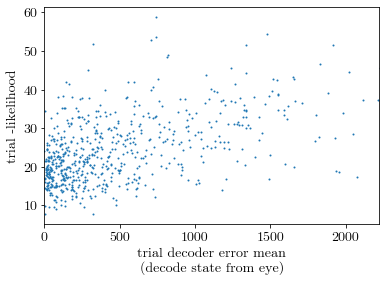

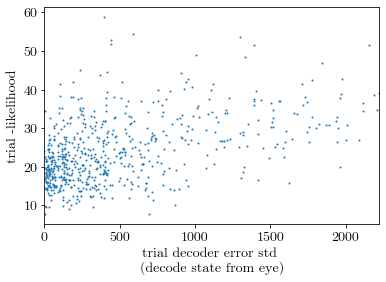

In [548]:
# belief eye corr
x,y=np.vstack(groundtruth)[:,4],np.vstack(belief)[:,6]
valid=~np.isnan(np.vstack(belief)[:,6])
x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
np.mean(cross_val_score(LinearRegression(),x,y))

lr=LinearRegression()
lr.fit(x,y)

sessionerrmu,sessionerrstd=[],[]
for b,s in zip(belief, groundtruth):
    x,y=np.vstack(s)[:,4],np.vstack(b)[:,6]
    valid=~np.isnan(y)
    x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
    pred=lr.predict(x)
    err=(y-pred)**2
    sessionerrmu.append(np.mean(err))
    sessionerrstd.append(np.std(err))
# sessionerrmu,sessionerrstd

plt.scatter(sessionerrmu, sessionll, s=1)
plt.xlim(0,2222)
plt.xlabel('trial decoder error mean\n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

plt.scatter(sessionerrstd, sessionll, s=1)
plt.xlim(0,2222)
plt.xlabel('trial decoder error std \n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

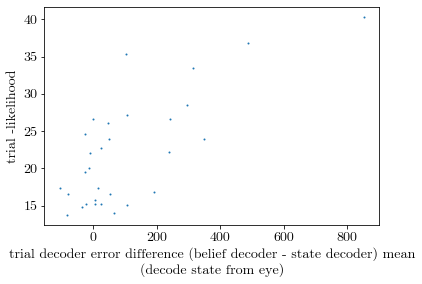

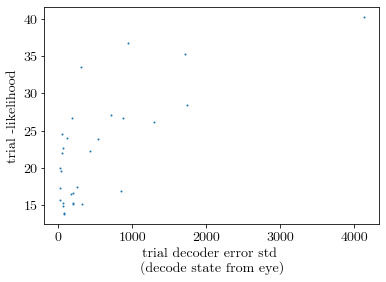

In [554]:
# belief eye corr
x,y=np.vstack(groundtruth)[:,4],np.vstack(belief)[:,6]
valid=~np.isnan(y)
x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
# np.mean(cross_val_score(LinearRegression(),x,y))
blr=LinearRegression()
blr.fit(x,y)

x,y=np.vstack(groundtruth)[:,4],np.vstack(groundtruth)[:,6]
valid=~np.isnan(y)
x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
slr=LinearRegression()
slr.fit(x,y)

sessionerrmu,sessionerrstd=[],[]
errordiff=[]
for b,s in zip(belief, groundtruth):
    x,y=np.vstack(s)[:,4],np.vstack(b)[:,6]
    yy=np.vstack(s)[:,6]

    valid=~np.isnan(y)
    x=x[valid].reshape(-1,1);y=y[valid].reshape(-1,1)
    yy[valid].reshape(-1,1)

    berr=(y-blr.predict(x))**2
    serr=(yy-slr.predict(x))**2
    diff=berr-serr

    sessionerrmu.append(np.mean(diff))
    sessionerrstd.append(np.std(diff))
# sessionerrmu,sessionerrstd

plt.scatter(sessionerrmu, sessionll, s=1)
# plt.xlim(0,2222)
plt.xlabel('trial decoder error difference (belief decoder - state decoder) mean\n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

plt.scatter(sessionerrstd, sessionll, s=1)
# plt.xlim(0,2222)
plt.xlabel('trial decoder error std \n(decode state from eye)')
plt.ylabel('trial -likelihood')
plt.show()

Text(0, 0.5, 'number of trials')

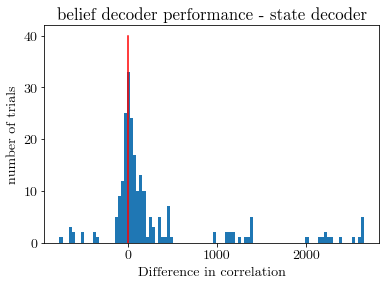

In [566]:
_=plt.hist(np.stack(diff).reshape(-1), bins=99)
plt.plot([0,0],[0,40], color='red')
plt.title('belief decoder performance - state decoder')
plt.xlabel("Difference in correlation")
plt.ylabel('number of trials')

# Post IRC

## compute belief 

In [1333]:
datapath = Path(resdir/f'{m}_mat_ruiyi/preirc_den_{idensity}')
savename = datapath.parent/(f'{m}_{idensity}'+datapath.name)
invfile=savename

finaltheta, finalcov, err = process_inv(
    invfile, removegr=False, usingbest=False)
print(finaltheta)

C:\Users\24455\Desktop\repo\mkdata\m51_mat_ruiyi\m51_1preirc_den_1
using ind:  -1 final logll :  15.665690626416888
tensor([[1.1921],
        [0.8381],
        [0.6041],
        [0.1469],
        [0.5000],
        [0.5000],
        [0.1300],
        [0.1900],
        [0.1500],
        [0.1900],
        [0.3500]])


In [1334]:
# compute belief
all_beliefs, all_covs={},{}

for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    states, actions, tasks=eval(m)[key]
    beliefs, covs = [], []
    ntrial = 1
    theta = finaltheta

    for ind in range(len(tasks)):
        if ind%100==0:
            print(ind)
        if len(actions[ind]) < 5:
            beliefs.append(np.nan)
            covs.append(np.nan)
        else:
            _, _, ep_beliefs, ep_covs = run_trials(agent=agent, env=env, phi=phi, theta=theta, task=tasks[ind], ntrials=ntrial,
                                                pert=None, given_obs=None, return_belief=True, given_action=actions[ind], given_state=states[ind])
            # beliefs.append(ep_beliefs[0]-ep_beliefs[0][0])
            init=torch.tensor(states[ind][0]).reshape(-1,1)
            beliefs.append(ep_beliefs[0]-ep_beliefs[0][0]+init) # make belief and state start at the same place
            covs.append(ep_covs[0])
            assert len(ep_beliefs[0]) == len(actions[ind])
    all_beliefs[f'{key}_irc_belief']=beliefs
    all_covs[f'{key}_irc_cov']=covs
     
notify('done computing belief')

0
100
0
0
100
200
300
0
100
200
0
100
200


## compute likelihood

In [1339]:
# model estimated likelihood (negative)
torch.manual_seed(42)
arg = Config()

env = ffacc_real.FireFlyPaper(arg)
env.debug=True
phi = torch.tensor([[0.5],
                    [pi/2],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.13],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    ])

agent_ = TD3.load('trained_agent/paper.zip')
agent = agent_.actor.mu.cpu()

def lltrial(state, action, task,samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    

irc_ll={}
for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    states, actions, tasks=eval(m)[key]

    sessionll=[]
    for i in range(len(states)):
        state, action, task=[states[i]], [actions[i]], [tasks[i]]
        ll=lltrial(state, action, task)
        sessionll.append(ll)
        if i%100==0: print(i)
    irc_ll[key+'_ll']=sessionll

notify('all done')

calculate loss time 0
0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 1
calculate loss time 0
calculate loss time 1
calculat

In [1341]:
eval(m).update(all_beliefs)
eval(m).update(all_covs)
eval(m).update(irc_ll)

## convert to eye coord

In [1342]:
key='m51s38'
beliefs, covs = eval(m)[f'{key}Ydownsampled_irc_irc_belief'],  eval(m)[f'{key}Ydownsampled_irc_irc_cov']
states, actions, tasks=eval(m)[f'{key}Ydownsampled_irc']
sessionll=eval(m)[f'{key}Ydownsampled_irc_ll']

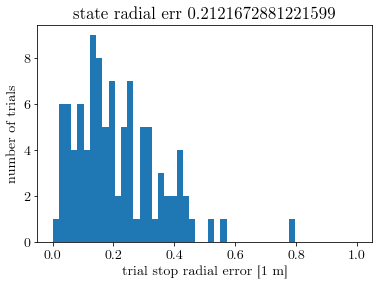

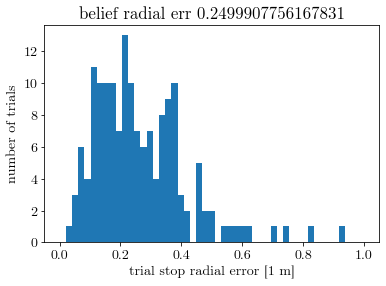

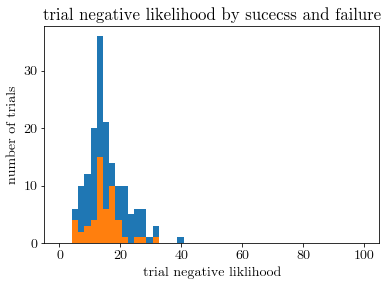

In [1344]:
# check belief reward vs state reward
cutoff=99 # the threshold for likelihood in histogram

belief_radial_err=[]
state_radial_err=[]
success_inds=[]
for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx,my=mx[-1],my[-1]
    epbelief_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    belief_radial_err.append(epbelief_radial_err.item())

for i, (ep_states, ep_covs, task) in enumerate(zip(states, covs,tasks)):
    mx, my, body_theta,  mv,mw= zip(*ep_states)
    mx,my=mx[-1],my[-1]
    ep_states_radial_err= ((mx-task[0])**2+(my-task[1])**2)**0.5
    state_radial_err.append(ep_states_radial_err.item())
    if ep_states_radial_err.item()<0.13: success_inds.append(i)
state_radial_err, belief_radial_err=np.array(state_radial_err), np.array(belief_radial_err)



# plot by likelihood cutoof
sortinds=np.argsort(sessionll)
_=plt.hist(state_radial_err[sortinds[:cutoff]], bins=np.linspace(0,1,50))
plt.title(f'state radial err {sum(state_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
plt.show()
_=plt.hist(belief_radial_err[sortinds[:222]],bins=np.linspace(0,1,50))
plt.title(f'belief radial err {sum(belief_radial_err[sortinds[:cutoff]])/cutoff}')
plt.xlabel('trial stop radial error [1 m]');plt.ylabel('number of trials')
plt.show()
# plt.scatter(state_radial_err, sessionll, s=4)
# plt.scatter(belief_radial_err, sessionll, s=4)
# plt.xlim(0,1)

# plot by success_inds
_=plt.hist(np.array(sessionll), bins=np.linspace(0,100,50))
_=plt.hist(np.array(sessionll)[success_inds], bins=np.linspace(0,100,50))
plt.title(f'trial negative likelihood by sucecss and failure')
plt.xlabel('trial negative liklihood');plt.ylabel('number of trials')
plt.show()

### convert to relative xy coord

In [1180]:
relative_beliefs=[]
relative_covs=[]

for ep_beliefs, ep_covs, task in zip(beliefs, covs,tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
    rel_lat, rel_for=convert_location_to_relative(
                            mx,
                            my,
                            body_theta,
                            task[0],
                            task[1])    
    relative_beliefs.append(np.stack([rel_lat, rel_for]).T)
    rotdegree=body_theta+180
    relativeposcov_=[]
    for degree, thiscov in zip(rotdegree, ep_covs):
        R=np.array([[np.cos(-degree/180*pi),-np.sin(-degree/180*pi)],[np.sin(-degree/180*pi),np.cos(-degree/180*pi)]])
        relativeposcov_.append(R.T@np.array(thiscov)[:2,:2]@R)
    relativeposcov_=np.stack(relativeposcov_)
    relative_covs.append(relativeposcov_)

### convert to eye coord

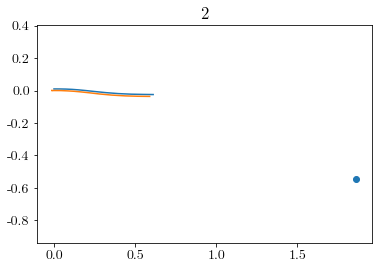

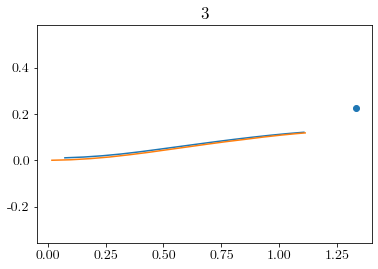

In [1183]:
a,b,c=states, actions, tasks
a[0].shape,b[0].shape,c[0],w,trialaction

for i in range(2,4):
    # y downsample, raw data
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # model data
    plt.plot(a[i][:,0],a[i][:,1]+0.01)
    plt.scatter( c[i][0],c[i][1])
    plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    plt.axis('equal')
    plt.title(i)
    plt.show()

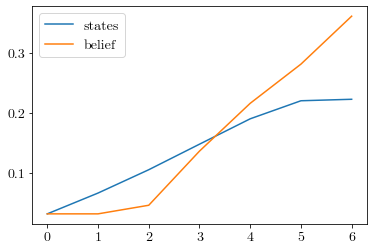

In [1185]:
i+=1
mx, my, body_theta,  mv,mw= zip(*states[i])
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='states')
# beliefs
ep_beliefs, ep_covs, task =beliefs[i], covs[i],tasks[i]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
mx, my, body_theta,  mv,mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
plt.plot(body_theta, label='belief')
plt.legend()

In [1222]:
session_eye_hori=[]
session_eye_vert=[]
session_eye_hori_=[]
session_eye_vert_=[]
for i in range(len(eval(m)[f'{key}Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)[f'{key}Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    session_eye_hori_.append(np.array(hor_theta_))
    session_eye_vert_.append(np.array(ver_theta_))


0.07257567552317468


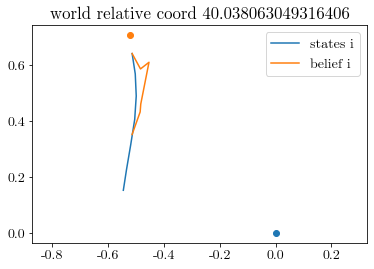

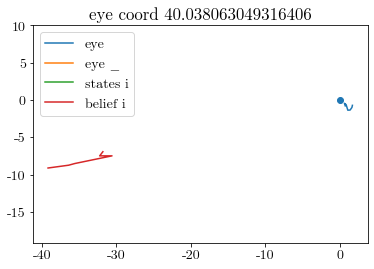

nan nan state
1235.3307903504744 50.002489876275376 belief


In [1313]:
from plot_ult import convert_location_to_relative
i -= 1
# # y downsampled
# rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
# plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale, label='ydownsample')
# # print(np.array(my)/worldscale)

# ------ overhead coord ------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my
# print('s',mx)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

# plt.plot(smy, smx, label='states')
# plt.plot(bmy, bmx, label='belief')
# plt.scatter(task[1], task[0])
# plt.scatter(0,0)
# plt.title(f'world coord {sessionll[i]}')
# plt.axis('equal')
# plt.legend()
# plt.show()


def mse(a, b):
    return sum((a-b)**2)/len(b)


print(mse(smx, smy) - mse(bmx, bmy))


# ------- eye coord -------------------
# states
mx, my, body_theta,  mv, mw = zip(*states[i])
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
smx, smy = mx, my

s_rel_lat, s_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])
# s_hor_theta_, s_ver_theta_ = convert_rel_location_to_angle(-s_rel_for, s_rel_lat)
rel_dist = ((mx-task[0])**2+(my-task[1])**2)**0.5
fx, fy = task[1], task[0]
body_x, body_y = my, mx
s_hor_theta_, s_ver_theta_ = convert_location_to_angle(
                                            abs(rel_dist).reshape(-1), fy.reshape(-1), fx.reshape(-1),
                                            (body_theta)+np.deg2rad(90), body_y.reshape(-1), body_x.reshape(-1),
                                            mx.reshape(-1), mx.reshape(-1),remove_pre=False)
# print(s_hor_theta_)

# beliefs
ep_beliefs, ep_covs, task = beliefs[i], covs[i], tasks[i]
mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
mx, my, body_theta,  mv, mw = np.array(torch.tensor(mx)), np.array(torch.tensor(my)), np.array(
    torch.tensor(body_theta)), np.array(torch.tensor(mv)), np.array(torch.tensor(mw))
bmx, bmy = mx, my

b_rel_lat, b_rel_for = convert_location_to_relative(
    mx,
    my,
    np.rad2deg(body_theta),
    task[0],
    task[1])

b_hor_theta_, b_ver_theta_ = convert_rel_location_to_angle(
    -b_rel_for, b_rel_lat)


# eye
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]
eye_hori_, eye_vert_ = session_eye_hori_[i], session_eye_vert_[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()


plt.plot(eye_hori, eye_vert, label='eye')
plt.plot(eye_hori_, eye_vert_+1, label='eye _')
plt.plot(s_hor_theta_, s_ver_theta_, label='states i')
plt.plot(b_hor_theta_, b_ver_theta_, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0, 0)
plt.title(f'eye coord {sessionll[i]}')
plt.show()


print(mse(s_hor_theta_.reshape(-1), eye_hori),
      mse(s_ver_theta_.reshape(-1), eye_vert), 'state')
print(mse(b_hor_theta_.reshape(-1), eye_hori),
      mse(b_ver_theta_.reshape(-1), eye_vert), 'belief')

In [1190]:
i-=1

session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))

    
eye_hori, eye_vert = session_eye_hori[i], session_eye_vert[i]

plt.plot(s_rel_for, s_rel_lat, label='states i')
plt.plot(b_rel_for, b_rel_lat, label='belief i')
plt.axis('equal')
plt.legend()
plt.scatter(0,0)
plt.scatter(task[1], task[0])
plt.title(f'world relative coord {sessionll[i]}')
plt.show()

KeyError: 'm53s31Ydownsampled'

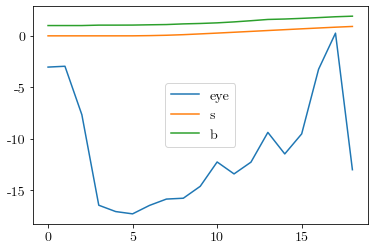

In [1095]:
plt.plot(eye_hori, label='eye')
plt.plot(smx, label='s')
plt.plot(bmx+1, label='b')
plt.legend()


In [1060]:
session_eye_hori=[]
session_eye_vert=[]
for i in range(len(eval(m)['m53s31Ydownsampled'])):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*eval(m)['m53s31Ydownsampled'][i][1])
    # model data
    # plt.plot(a[i][:,0],a[i][:,1],)
    # plt.scatter( c[i][0],c[i][1],)
    # plt.plot(np.array(my)/worldscale,np.array(mx)/worldscale)
    # plt.axis('equal')
    # plt.title(i)
    # plt.show()
    session_eye_hori.append(np.array(hor_theta))
    session_eye_vert.append(np.array(ver_theta))
session_eye_hori

[array([-4.64084519e+00, -5.00796834e+00, -7.39122523e-01, -4.52904031e-03,
         1.80025566e+01,  3.05531747e+01,  2.81544588e+01, -7.70937955e-01,
        -7.81069526e+00, -8.72520598e+00]),
 array([ -7.57641414,  -5.61990864,  -5.3950767 ,  -4.97662093,
         -1.041731  ,  -2.84741668,  -2.79724685,  -2.5382783 ,
         -2.83908768,  -2.72914828,  -9.17526953, -24.06205907,
        -23.84035447]),
 array([ 14.50159982,  13.23620751,  -5.04948299, -19.48241436,
        -21.44129776, -22.90367867, -23.13217085, -22.47333269,
        -22.42656842, -23.25709444, -23.60979955, -22.8862344 ]),
 array([ -8.07339682,  -8.25123327, -23.59964427, -24.41934305,
        -24.06822339, -23.70551637, -23.55667451, -23.38276347,
        -23.14971666, -23.01350964, -19.99233456]),
 array([-11.29712727, -11.17490118, -14.93873327, -15.7383079 ,
        -15.72529215, -15.4976962 , -15.31994769, -12.06065565,
        -14.705995  , -17.69495874, -17.56148866, -25.67567219,
        -37.60097234, 

# analysis

## belief eye correlation


In [642]:
ll=irc_ll['m53s31Ydownsampled_irc_ll']
len(ll)
y=eval(m)['m53s31Ydownsampled']
trial_idces, yy = zip(*y)
all_hor_theta=[]
for itrial in range(len(trial_idces)):
    rel_dist, rel_ang, abs_dist, abs_ang,hor_theta, ver_theta, hor_theta_, ver_theta_,fx, fy, mx, my, mv, mw=zip(*yy[itrial])
    all_hor_theta.append(hor_theta)
len(all_hor_theta),len(beliefs), len(covs), len(states)

748

## 